In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

/home/dan/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# read in the car dataset
df=pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data',header=None)

columns= ['symboling','normalized-losses','make','fuel-type','aspiration','num-of-doors','body-style','drive-wheels','engine-location','wheel-base','length','width','height','curb-weight','engine-type','num-of-cylinders','engine-size','fuel-system','bore','stroke','compression-ratio','horsepower','peak-rpm','city-mpg','highway-mpg','price']
df.columns=columns
# Use head to view the first few rows
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450


In [3]:
df.shape

(205, 26)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized-losses    205 non-null object
make                 205 non-null object
fuel-type            205 non-null object
aspiration           205 non-null object
num-of-doors         205 non-null object
body-style           205 non-null object
drive-wheels         205 non-null object
engine-location      205 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
engine-type          205 non-null object
num-of-cylinders     205 non-null object
engine-size          205 non-null int64
fuel-system          205 non-null object
bore                 205 non-null object
stroke               205 non-null object
compression-ratio    205 non-null float64
horsepower           205 non-nul

In [5]:
df.columns

Index(['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
       'num-of-doors', 'body-style', 'drive-wheels', 'engine-location',
       'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type',
       'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke',
       'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'price'],
      dtype='object')

In [6]:
df['num-of-doors'].unique()

array(['two', 'four', '?'], dtype=object)

In [7]:
door_map = {
    'two': 2,
    'four': 4,
    '?': 3
}
df['num-of-doors'] = df['num-of-doors'].map(lambda n: door_map[n])
df['num-of-doors'].unique()

array([2, 4, 3])

In [8]:
df['fuel-type'].unique()

array(['gas', 'diesel'], dtype=object)

In [9]:
df['fuel-type'] = df['fuel-type'].map(lambda ft: 1 if ft == 'gas' else 2)
df['fuel-type'].unique()

array([1, 2])

In [10]:
df['aspiration'].unique()

array(['std', 'turbo'], dtype=object)

In [11]:
df['aspiration'] = df['aspiration'].map(lambda ft: 1 if ft == 'std' else 2)
df['aspiration'].unique()

array([1, 2])

In [12]:
df['body-style'].unique()

array(['convertible', 'hatchback', 'sedan', 'wagon', 'hardtop'], dtype=object)

In [13]:
df['drive-wheels'].unique()

array(['rwd', 'fwd', '4wd'], dtype=object)

In [14]:
df['drive-wheels'] = df['drive-wheels'].map(lambda dw: 4 if dw == '4wd' else 2)
df['drive-wheels'].unique()

array([2, 4])

In [15]:
df['engine-location'].unique()

array(['front', 'rear'], dtype=object)

In [16]:
df['engine-location'] = df['engine-location'].map(lambda el: 1 if el == 'front' else 2)
df['engine-location'].unique()

array([1, 2])

In [17]:
df['num-of-cylinders'].unique()

array(['four', 'six', 'five', 'three', 'twelve', 'two', 'eight'], dtype=object)

In [18]:
num_map = {
    'two': 2,
    'three': 3,
    'four': 4,
    'five': 5,
    'six': 6,
    'eight': 8,
    'twelve': 12
}
df['num-of-cylinders'] = df['num-of-cylinders'].map(lambda nc: num_map[nc])
df['num-of-cylinders'].unique()

array([ 4,  6,  5,  3, 12,  2,  8])

In [19]:
numeric_columns = ['symboling', 'normalized-losses', 'fuel-type', 'aspiration',
       'num-of-doors', 'drive-wheels', 'engine-location',
       'wheel-base', 'length', 'width', 'height', 'curb-weight',
       'num-of-cylinders', 'engine-size', 'bore', 'stroke',
       'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg','price']
numeric_df = df[numeric_columns].convert_objects(convert_numeric=True)
numeric_df.sample(10)

/home/dan/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


,symboling,normalized-losses,fuel-type,aspiration,num-of-doors,drive-wheels,engine-location,wheel-base,length,width,...,num-of-cylinders,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
23,1,118.0,1,2,2,2,1,93.7,157.3,63.8,...,4,98,3.03,3.39,7.6,102.0,5500.0,24,30,7957.0
194,-2,103.0,1,1,4,2,1,104.3,188.8,67.2,...,4,141,3.78,3.15,9.5,114.0,5400.0,23,28,12940.0
93,1,103.0,1,1,4,2,1,94.5,170.2,63.8,...,4,97,3.15,3.29,9.4,69.0,5200.0,31,37,7349.0
68,-1,93.0,2,2,4,2,1,110.0,190.9,70.3,...,5,183,3.58,3.64,21.5,123.0,4350.0,22,25,28248.0
13,0,188.0,1,1,4,2,1,101.2,176.8,64.8,...,6,164,3.31,3.19,9.0,121.0,4250.0,21,28,21105.0
72,3,142.0,1,1,2,2,1,96.6,180.3,70.5,...,8,234,3.46,3.10,8.3,155.0,4750.0,16,18,35056.0
153,0,77.0,1,1,4,2,1,95.7,169.7,63.6,...,4,92,3.05,3.03,9.0,62.0,4800.0,31,37,6918.0
88,-1,137.0,1,1,4,2,1,96.3,172.4,65.4,...,4,110,3.17,3.46,7.5,116.0,5500.0,23,30,9279.0
58,3,150.0,1,1,2,2,1,95.3,169.0,65.7,...,2,80,NaN,NaN,9.4,135.0,6000.0,16,23,15645.0
174,-1,65.0,2,2,4,2,1,102.4,175.6,66.5,...,4,110,3.27,3.35,22.5,73.0,4500.0,30,33,10698.0


In [20]:
numeric_df = numeric_df.fillna(numeric_df.mean())
numeric_df.sample(10)

,symboling,normalized-losses,fuel-type,aspiration,num-of-doors,drive-wheels,engine-location,wheel-base,length,width,...,num-of-cylinders,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
101,0,128.0,1,1,4,2,1,100.4,181.7,66.5,...,6,181,3.43,3.27,9.0,152.000000,5200.000000,17,22,13499.0
115,0,161.0,1,1,4,2,1,107.9,186.7,68.4,...,4,120,3.46,3.19,8.4,97.000000,5000.000000,19,24,16630.0
3,2,164.0,1,1,4,2,1,99.8,176.6,66.2,...,4,109,3.19,3.40,10.0,102.000000,5500.000000,24,30,13950.0
75,1,122.0,1,2,2,2,1,102.7,178.4,68.0,...,4,140,3.78,3.12,8.0,175.000000,5000.000000,19,24,16503.0
121,1,154.0,1,1,4,2,1,93.7,167.3,63.8,...,4,90,2.97,3.23,9.4,68.000000,5500.000000,31,38,6692.0
125,3,186.0,1,1,2,2,1,94.5,168.9,68.3,...,4,151,3.94,3.11,9.5,143.000000,5500.000000,19,27,22018.0
68,-1,93.0,2,2,4,2,1,110.0,190.9,70.3,...,5,183,3.58,3.64,21.5,123.000000,4350.000000,22,25,28248.0
84,3,122.0,1,2,2,2,1,95.9,173.2,66.3,...,4,156,3.59,3.86,7.0,145.000000,5000.000000,19,24,14489.0
15,0,122.0,1,1,4,2,1,103.5,189.0,66.9,...,6,209,3.62,3.39,8.0,182.000000,5400.000000,16,22,30760.0
130,0,122.0,1,1,4,2,1,96.1,181.5,66.5,...,4,132,3.46,3.90,8.7,104.256158,5125.369458,23,31,9295.0


In [21]:
numeric_df['engine-log'] = np.log(numeric_df['engine-size'])

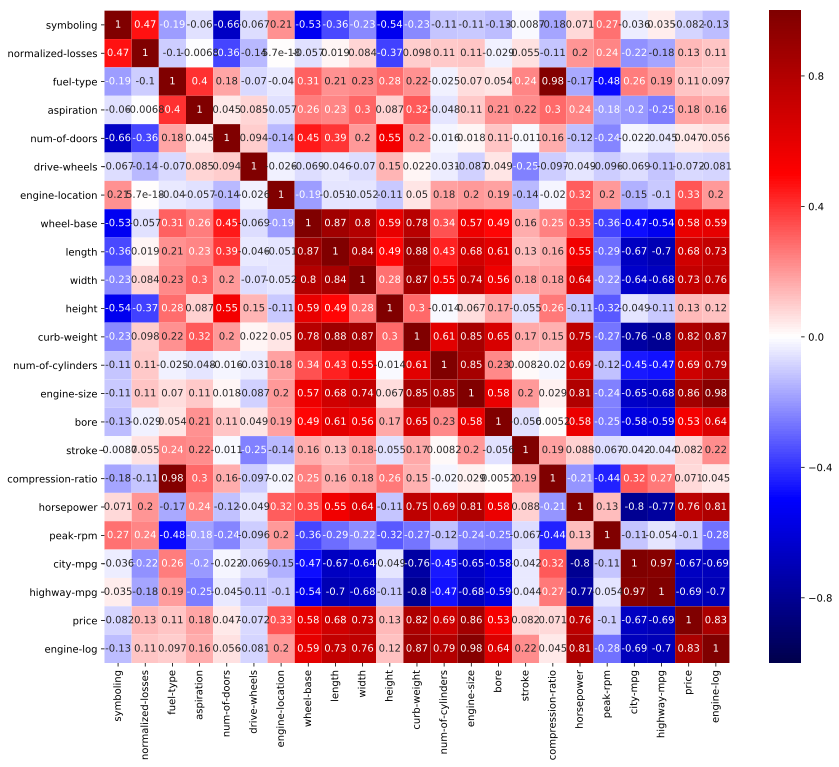

In [22]:
plt.figure(figsize=(14,12))
sns.heatmap(numeric_df.corr(), vmin=-1, vmax=1, center=0, cmap='seismic', annot=True);

In [23]:
clean_columns = numeric_df.columns.map(lambda c: c.replace('-', ''))
numeric_df.columns = clean_columns
clean_columns_sans_price = [c for c in clean_columns if c != 'price']

formula = 'price ~ {}'.format(' + '.join(clean_columns_sans_price))
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices(formula, data=numeric_df, return_type="dataframe")

# Create your model
model = sm.OLS(y,X)
# Fit your model to your training set
fit = model.fit()
# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     53.11
Date:                Thu, 19 Apr 2018   Prob (F-statistic):           2.86e-67
Time:                        09:53:27   Log-Likelihood:                -1923.9
No. Observations:                 205   AIC:                             3894.
Df Residuals:                     182   BIC:                             3970.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          1.55e+04   2.28e+04      0.679      0.498   -2.95e+04    6.05e+04
symboling         -158.7414    310.306     -0.512      0.610    -771.002     453.519
normalizedlosses    10.1217      9.095      1.113      0.267      -7.824      28.067
fueltype          1872.8843   7253.779      0.258      0.797   -1.24e+04    1.62e+04
aspiration        1134.2421    997.672      1.137      0.257    -834.249    3102.733
numofdoors          -4.3248    333.178     -0.013      0.990    -661.713     653.063
drivewheels       -292.4670    635.299     -0.460      0.646   -1545.966     961.032
enginelocation    1.473e+04   2333.012      6.315      0.000    1.01e+04    1.93e+04
wheelbase           39.7960    115.921      0.343      0.732    -188.925     268.517
length               5.1134     59.028      0.087      0.931    -111.355     121.581
width              569.2532    251.564      2.263      0.025      72.896    1065.610
height             135.2624    149.530      0.905      0.367    -159.773     430.298
curbweight           2.2130      1.806      1.226      0.222      -1.350       5.776
numofcylinders   -2046.9663    747.488     -2.738      0.007   -3521.822    -572.110
enginesize         277.8810     34.827      7.979      0.000     209.165     346.597
bore             -4821.3587   1749.895     -2.755      0.006   -8274.049   -1368.669
stroke           -3609.6246   1021.400     -3.534      0.001   -5624.933   -1594.317
compressionratio   -28.9138    516.053     -0.056      0.955   -1047.130     989.303
horsepower          -7.8343     19.791     -0.396      0.693     -46.884      31.215
peakrpm              1.5253      0.745      2.046      0.042       0.055       2.996
citympg           -106.1266    189.122     -0.561      0.575    -479.280     267.027
highwaympg          -1.5620    170.122     -0.009      0.993    -337.228     334.104
enginelog        -1.643e+04   4760.925     -3.450      0.001   -2.58e+04   -7032.269
==============================================================================
Omnibus:                       58.031   Durbin-Watson:                   0.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              208.657
Skew:                           1.095   Prob(JB):                     4.91e-46
Kurtosis:                       7.431   Cond. No.                     6.21e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.21e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
# Create an empty model
lr1 = LinearRegression()

# Choose the predictor variables, here all but the first which is the response variable
# This model is analogous to the Y ~ X1 + X3 + X6 model
X = numeric_df[['wheelbase','enginesize','curbweight','horsepower','bore']]
# Choose the response variable(s)
y = numeric_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=180)
# Fit the model to the full dataset
lr1.fit(X_train,y_train)
# Print out the R^2 for the model against the full dataset
train_score = lr1.score(X_train, y_train)
test_score = lr1.score(X_test,y_test)
[train_score, test_score]

[0.79369528676888512, 0.70419900486977327]

In [26]:
from sklearn.model_selection import cross_val_score

In [27]:
reg = LinearRegression()
scores = cross_val_score(reg, X, y, cv=5, scoring='r2')
scores

array([ 0.76758104,  0.86729824,  0.16929771,  0.5352988 ,  0.3968677 ])

In [28]:
lr2 = LinearRegression()
X['make'] = df['make']
X = pd.get_dummies(X, columns=['make'])
scores = cross_val_score(lr2, X, y, cv=5, scoring='r2')
scores

/home/dan/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


array([ 0.64344639,  0.76224918,  0.52508138,  0.55922904,  0.66095485])